In [274]:
import numpy as np
import os

data_path = '/home/patika/Documents/projects/irl_sfm/data/demonstrations/sfm/continuous_poses_1/new/'
out_path = '/home/patika/phd/yigit_phd_thesis/cnmp/data/sfm/continuous_poses_1/new/combined_1/'

try:
    os.mkdir(out_path)
except:
  pass
try:
    os.mkdir(f'{out_path}demonstrations')
except:
  pass
try:
    os.mkdir(f'{out_path}novel')
except:
  pass

demonstrations = []
novel_demonstrations = []

for filename in os.listdir(data_path):
    if filename.endswith(".npy"):
        path = os.path.join(data_path, filename)
        demonstrations.append(np.load(path, allow_pickle=True, encoding='latin1'))
#         print(f'{len(demonstrations)-1}: {path}')

novel_data_path = os.path.join(data_path, 'novel/')
for filename in os.listdir(novel_data_path):
    if filename.endswith(".npy"):
        path = os.path.join(novel_data_path, filename)
        novel_demonstrations.append(np.load(path, allow_pickle=True, encoding='latin1'))

num_demos = len(demonstrations)
num_novel = len(novel_demonstrations)

In [275]:
print(num_demos)
print(num_novel)

5
2


In [276]:
from tqdm import tqdm

desired_len = 400 # min_len
x_dim, gamma_dim, y_dim = 2, 2, 2

ldx, ldy, ldg = [], [], []

n_X = np.zeros((num_novel, desired_len, x_dim))
n_Gamma =  np.zeros((num_novel, desired_len, gamma_dim))
n_Y = np.zeros((num_novel, desired_len, y_dim))

thrown = 0

for i, demo in enumerate(tqdm(demonstrations, desc="Processing")):
    max_v_y = np.max(demo[:, x_dim+gamma_dim:x_dim+gamma_dim+y_dim])
    min_v_y = np.min(demo[:, x_dim+gamma_dim:x_dim+gamma_dim+y_dim])
#     if max_v_y > 2.5 or min_v_y < -2.5:
#         thrown += 1
#         continue
    len_demo = len(demo)
#     print(len_demo)
    indices = np.linspace(11, len_demo-1, desired_len, dtype=int)  # <desired_len>-many indices are selected uniformly
    x, gmm, y = np.zeros((desired_len, x_dim)), np.zeros((desired_len, gamma_dim)), np.zeros((desired_len, y_dim))
    for new_ind, old_ind in enumerate(indices):
        x[new_ind] = demo[old_ind][:x_dim]
        gmm[new_ind] = demo[old_ind][x_dim:x_dim+gamma_dim]
        y[new_ind] = demo[old_ind][x_dim+gamma_dim:x_dim+gamma_dim+y_dim]
    
    ldx.append(x)
    ldy.append(y)
    ldg.append(gmm)


num_demos = len(ldx)

d_X = np.zeros((num_demos, desired_len, x_dim))
d_Gamma =  np.zeros((num_demos, desired_len, gamma_dim))
d_Y = np.zeros((num_demos, desired_len, y_dim))

for i in tqdm(range(num_demos), desc="Copying"):
    d_X[i] = ldx[i]
    d_Gamma[i] = ldg[i]
    d_Y[i] = ldy[i]

print(f'Thrown: {thrown}')
#############
# novel case
#############

for i, demo in enumerate(novel_demonstrations):
    len_demo = len(demo)
    indices = np.linspace(11, len_demo-1, desired_len, dtype=int)  # <desired_len>-many indices are selected uniformly
    x, gmm, y = np.zeros((desired_len, x_dim)), np.zeros((desired_len, gamma_dim)), np.zeros((desired_len, y_dim))
    for new_ind, old_ind in enumerate(indices):
        x[new_ind] = demo[old_ind][:x_dim]
        gmm[new_ind] = demo[old_ind][x_dim:x_dim+gamma_dim]
        y[new_ind] = demo[old_ind][x_dim+gamma_dim:x_dim+gamma_dim+y_dim]
    n_X[i] = x
    n_Gamma[i] = gmm
    n_Y[i] = y

Copying: 100%|██████████| 5/5 [00:00<00:00, 29208.25it/s]

Thrown: 0


[Text(0, 0.5, 'speed'), Text(0.5, 0, 'step')]

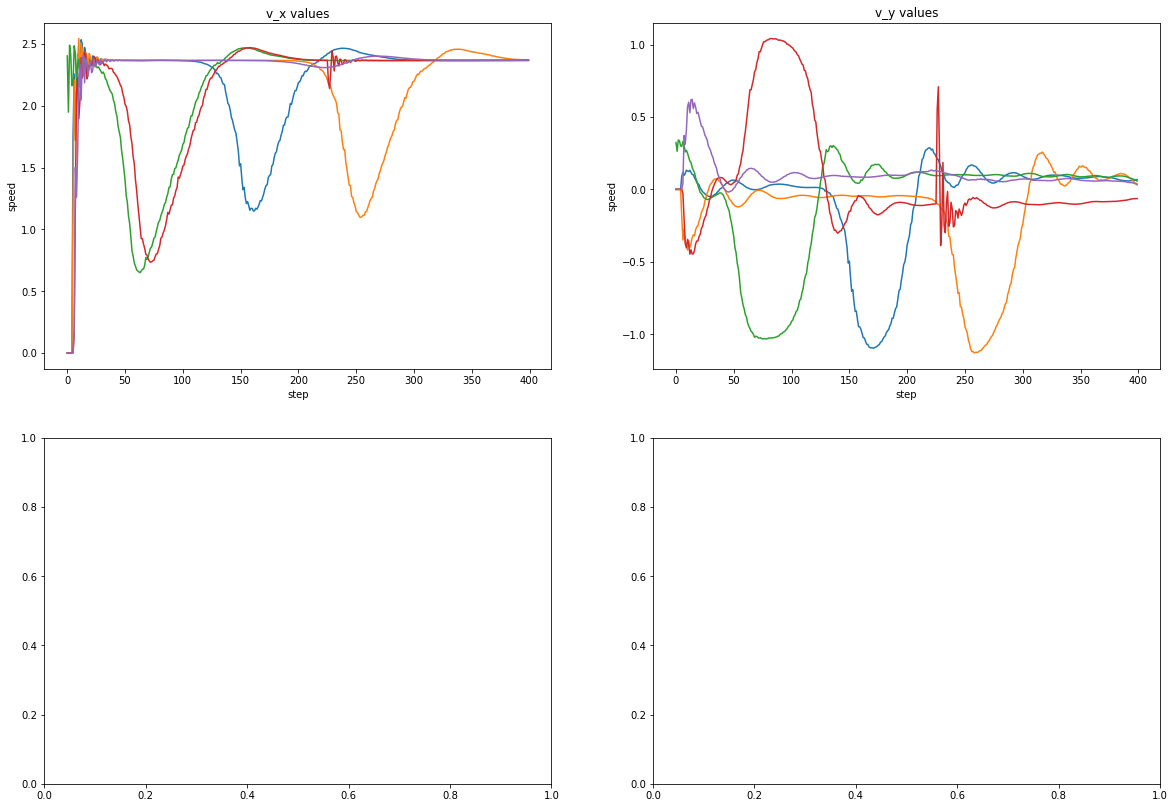

In [277]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 14]

fig, axs = plt.subplots(2, 2)
for i in range(num_demos):
    axs[0, 0].plot(range(len(d_Y[i])), d_Y[i][:, 0])  # v_x
axs[0, 0].set_title('v_x values')
axs[0, 0].set(xlabel='step', ylabel='speed')

for i in range(num_demos):
    axs[0, 1].plot(range(len(d_Y[i])), d_Y[i][:, 1])  # v_y
axs[0, 1].set_title('v_y values')
axs[0, 1].set(xlabel='step', ylabel='speed')

In [149]:
print(len(d_Y))

1


In [150]:
num_val = 553  # 553 out of 8553 

x_train, x_val, y_train, y_val, gamma_train, gamma_val = [], [], [], [], [], []
val_indices = np.sort(np.random.choice(range(num_demos-1), num_val, replace=False))

for i in range(num_demos):
    if i in val_indices:  # validation instance
#         print(f'val: {i}')
        x_val.append(d_X[i])
        gamma_val.append(d_Gamma[i])
        y_val.append(d_Y[i])
    else:  # training instance
        x_train.append(d_X[i])
        gamma_train.append(d_Gamma[i])
        y_train.append(d_Y[i])
        
np.save(out_path + 'demonstrations/' + 'd_x.npy', np.array(x_train))
np.save(out_path + 'demonstrations/' + 'd_y.npy', np.array(y_train))
np.save(out_path + 'demonstrations/' + 'd_gamma.npy', np.array(gamma_train))
np.save(out_path + 'demonstrations/' + 'v_d_x.npy', np.array(x_val))
np.save(out_path + 'demonstrations/' + 'v_d_y.npy', np.array(y_val))
np.save(out_path + 'demonstrations/' + 'v_d_gamma.npy', np.array(gamma_val))

#############
# novel case
#############

np.save(out_path + 'novel/' + 'd_x.npy', np.array(n_X))
np.save(out_path + 'novel/' + 'd_y.npy', np.array(n_Y))
np.save(out_path + 'novel/' + 'd_gamma.npy', np.array(n_Gamma))

ValueError: 'a' cannot be empty unless no samples are taken